# 3. Feladatsor: megoldások
*(Normálegyenlet, iteratív megoldók, gradiens-ereszkedés)*

### Hogyan készíthetünk ilyen fixpont-iterációt I.

Legegyszerűbb megközelités (egyszerű- vagy **Richardson-iteráció**)
$$
\begin{align}
Ax &= b\\
0 &= b - Ax \\
x &= x - Ax + b \\
\\
f(x) &= (I-A)x +b
\end{align}
$$

Egy gond ezzel, hogy sokszor az $I-A$ mátrix spektrálsugara még nem elég kicsi. Ezen segithetünk egy $\omega$ paraméter bevezetésével:
$$
\begin{align}
Ax &= b\\
0 &= \omega(b - Ax) \\
x &= x - \omega Ax + \omega b \\
\\
f_{\omega}(x) &= (I-\omega A)x +\omega b
\end{align}
$$

Itt $\rho(I-\omega A) < 1$ pontosan akkor teljesül, ha az $A$ mátrix $\lambda$ sajátértékeire $| 1 - \omega \lambda | < 1$. A konvergencia akkor a leggyorsabb, ha ez a spektrálsugár minél kisebb. Például ha az $A$ mátrix szimmetrikus és pozitiv definit akkor az optimális választás $\omega$-ra: 

$$\omega_{\text{opt}} = \frac{2}{\lambda_{\min} + \lambda_{\max}}.$$

### 2. Feladat

Miért ez az $\omega_{\text{opt}}$?

Megoldás: $\rho(I-\omega A)=\max\{|1-\omega \lambda_{\min}|,|1-\omega \lambda_{\max}|\}$ SZPD $A$ esetén, ezt az értéket szeretnénk minimalizálni. $\omega_{\text{opt}} = \frac{2}{\lambda_{\min} + \lambda_{\max}}$ esetén ezek

$$|1-\omega_{\text{opt}} \lambda_{\min}|=\bigg|1- \dfrac{2\lambda_{\min}}{\lambda_{\min}+\lambda_{\max}}\bigg|=\bigg|\dfrac{\lambda_{\max}-\lambda_{\min}}{\lambda_{\min}+\lambda_{\max}}\bigg|=\bigg|\dfrac{\lambda_{\min}-\lambda_{\max}}{\lambda_{\min}+\lambda_{\max}}\bigg|=\bigg|1- \dfrac{2\lambda_{\max}}{\lambda_{\min}+\lambda_{\max}}\bigg|=|1-\omega_{\text{opt}} \lambda_{\max}|,$$

azaz a 2 érték megegyezik, és egyszerűen látható, hogy itt lesz minimális a kettő maximuma.

### P1. Feladat
Írjunk programot, amely egy $A$ SZPD mátrix esetén egy ábrán ábrázolja az $I-\omega A$ mátrix sajátértékeinek abszolútértékét az $\omega$ függvényeként. Bemeneti paraméterek lehetnek a mátrix sajátértékei.

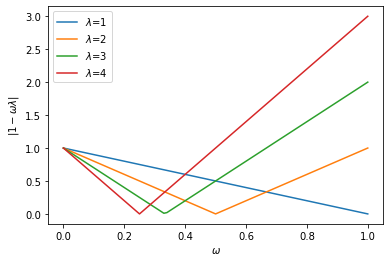

In [18]:
import numpy as np
import matplotlib.pyplot as plt

def vplot(*lambdas: float, omega_min: float = 0., omega_max: float = 1.):
    assert len(lambdas) >= 1
    assert omega_max > omega_min
    
    ax = plt.axes()
    
    omegas = np.linspace(omega_min, omega_max, int(101*abs(omega_max - omega_min)))
    for lam in lambdas:
        ax.plot(omegas,  abs(1 - omegas*lam), label=fr"$\lambda$={lam}")

    ax.legend()
    ax.set_xlabel(r"$\omega$")
    ax.set_ylabel(r"$|1-\omega\lambda|$")

vplot(1,2,3,4)

### P2. Feladat
Írjunk általános függvényt a fenti, $A = M-N$ felbontással adódó iterációkhoz, majd ezzel implementáljuk a tanult iterációkat.

Alkalmazzunk is ezek közül egy olyat, amit értelmes az
$$
\left[\matrix{2 & -1 \cr -1 & 2}\right] x= \left[ \matrix{1 \cr 3} \right]
$$
egyenlet megoldására. Addig iteráljunk, míg két szomszédos iterált $\| \cdot \|_2$ szerinti távolsága $10^{-4}$ alá nem csökken.

In [19]:
from dataclasses import dataclass
from functools import wraps
from typing import Callable

Matrix = np.ndarray
Vector = np.ndarray

@dataclass
class IterationResult:
    x: Vector
    success: bool
    abs_err: float
    rel_err: float
    step_num: int

@dataclass
class StoppingCondition:
    norm: Callable[(Vector,), float]
    atol: float
    rtol: float
    max_steps: int

def mn_iteration(
    extract_m: Callable[(Matrix,), Matrix],
    A: Matrix,
    b: Vector, 
    x0: Vector, 
    stopping_condition: StoppingCondition
) -> IterationResult:
    
    M = extract_m(A)
    N = M - A
    # M^{-1}N
    B = np.linalg.solve(M, N)
    # M^{-1}b
    r = np.linalg.solve(M, b)

    is_success = False
    x = x0
    for step_num in range(1, stopping_condition.max_steps+1):
        d = B@x + r - x;
        x = x + d
        
        # Ha d kicsi, azaz x_n es x_{n+1} kozel vannak, 
        # azaz x_n es f(x_n) kozel vannak,
        # azaz kozel vagyunk a fixponthoz.
        abs_err = stopping_condition.norm(d);

        if all([
            abs_err <= stopping_condition.atol,
            abs_err <= stopping_condition.rtol * stopping_condition.norm(x)
        ]):
            is_success = True
            break

    # tul sok lepes eseten sikertelen
    is_success &= (step_num <= stopping_condition.max_steps)

    return IterationResult(
        x,
        is_success,
        abs_err,
        abs_err/stopping_condition.norm(x),
        step_num
    )

TypeError: Callable[args, result]: args must be a list. Got (<class 'numpy.ndarray'>,)

In [20]:
from functools import partial

def make_jor_iteration(omega):
    return partial(mn_iteration, lambda A: 1/omega*np.diag(np.diag(A)))

def make_sor_iteration(omega):
    return partial(mn_iteration, lambda A: 1/omega*np.diag(np.diag(A)) + np.tril(A, -1))

In [21]:
jacobi_it = make_jor_iteration(omega=1)

NameError: name 'mn_iteration' is not defined

In [8]:
A = np.array([
    [2, -1],
    [-1, 2],
])

b = np.array([1, 3])
x0 = np.zeros((2,))

stopping_condition = StoppingCondition(
    partial(np.linalg.norm, ord=2), # nem kell a partial ha 2-es norma
    atol=1e-4,
    rtol=np.inf,
    max_steps=10**10,
)

NameError: name 'StoppingCondition' is not defined

In [9]:
iteration_result = jacobi_it(A, b, x0, stopping_condition)

NameError: name 'jacobi_it' is not defined

In [10]:
iteration_result

NameError: name 'iteration_result' is not defined

In [11]:
A @ iteration_result.x

NameError: name 'iteration_result' is not defined

In [29]:
import numpy as np

def gradient_descent(A, b, x0, tol=1e-6, max_iter=1000):
    """
    Gradient Descent method for solving symmetric positive definite (SPD) linear systems.

    Parameters:
        A (numpy.ndarray): The symmetric positive definite matrix.
        b (numpy.ndarray): The right-hand side vector.
        x0 (numpy.ndarray): Initial guess for the solution.
        tol (float): Tolerance for convergence.
        max_iter (int): Maximum number of iterations.

    Returns:
        x (numpy.ndarray): Solution vector.
        iter (int): Number of iterations performed.
        is_success (bool): True if the method was successful, False otherwise.
    """
    is_success = False
    x = x0.copy()
    for iter in range(max_iter):
        r = A @ x - b  # Compute residual
        if np.linalg.norm(r) < tol:
            is_success = True
            break  # Convergence achieved

        # Compute step size
        omega = r @ r / (r @ (A @ r))
        d = -omega * r

        x = x + d  # Update solution

    return x, iter + 1, is_success

# Example usage: (nem szimmetrikus mátrix esetén a normálegyenlettel használható a gradiens ereszkedés : A^T*A*x=A^T*b megoldása megegyezik az A*x=b megoldásával, ha A invertálható)
A = np.array([[2, -1, 0],
              [-3, 0, -1],
              [0, -1, 2]])
b = np.array([5, -6, 6])
x0 = np.zeros_like(b)

solution, iterations, is_success = gradient_descent(A.T@A, A.T@b, x0)
print("Solution:", solution)
print("Number of iterations:", iterations)
print("Success:", is_success)
print(A@solution)

Solution: [ 1.37500006 -2.24999934  1.87500031]
Number of iterations: 74
Success: True
[ 4.99999945 -6.00000049  5.99999997]
